In [71]:
# Units of variables given in the dataset:
#    elevation: meters above sea level
#    g: mm water equivalent per meter (db/dz)
#    continentality: degrees Celsius
#    cloud cover: percentage
#    summer temperature: degrees Celsius
#    precipitation: mm per year
#    average winter precipitation: mm per month 

# NOTE: climate variables are given from climatological gridded data (CRU) provided for the whole globe on ca 50x50 km grid
#
# Variables:
#                       g: [1x136 double]  glacier mass balance gradient (as an average over the observed period)
#        median_elevation: [1x136 double]  Median glacier elevation (derived from glacier hypsometry: glacier area vs elevation)
#      summer_temperature: [1x136 double]  Summer near-surface air temperature over a grid cell (ca 50x50 km) covering the glacier (averaged over the observed period)
#           precipitation: [1x136 double]  Total annaul precipitation over a grid cell (ca 50x50 km) covering the glacier (averaged over the observed period)
#                     lat: [1x136 double]  Geographical latitude of the glacier (in degrees)
#           max_elevation: [1x136 double]  Maximum glacier elevation
#                 WGMS ID: [1x136 int64]   Given glacier ID (from World Glacier Monitoring Service)
#    winter_precipitation: [1x136 double]  Same as for precipation but derived only over winter months 
#                     lon: [1x136 double]  Geographical longitude of the glacier (in degrees)
#             cloud_cover: [1x136 double]  Annual cloud cover over a grid cell (ca 50x50 km) covering the glacier (averaged over the observed period)
#          continentality: [1x136 double]  Maximum monthly temperature minus minimum monthly temperature over a year (over a grid cell covering the glacier and averaged over the observed period). The larger the continentality index the climate is more continental (rather than maritime). 


In [72]:
#import all required libraries etc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import ipywidgets

#NOTE: to get ipywidgets to work, need to enter the following into the command line:
#    conda install -c conda-forge ipywidgets
#    conda install -c conda-forge nodejs
#    jupyter lab --version
#Based on the version of jupyter lab, check https://npm.taobao.org/package/@jupyter-widgets/jupyterlab-manager for next command
#The final command should look something like:
#    jupyter labextension install @jupyter-widgets/jupyterlab-manager@1.0
#where the -manager@XX changes based on the version of jupyter that you have

In [73]:
#load the data and check it out

data = pd.read_csv('glaciers.csv')
data.head()

,g,median_elevation,summer_temperature,precipitation,lat,max_elevation,winter_precipitation,lon,cloud_cover,continentality
0,8.102728,1071.00,7.626667,483.990,-54.78,1172.5,36.273333,-68.40,63.393750,8.395
1,1.860170,2660.00,11.663333,1637.810,47.04,2950.0,91.578333,12.97,61.731667,18.830
2,9.194071,2560.00,14.881667,1521.845,47.48,2910.0,83.785000,13.62,61.529583,20.045
3,4.162200,3039.75,11.683333,1550.760,46.80,3715.5,93.790000,10.77,62.957083,18.725
4,4.411077,2795.00,10.561667,1726.480,46.85,3140.0,110.065000,10.15,64.265417,17.855


In [74]:
#clean data -- g<0 is non physical and this data point should be removed

data = data.drop(np.argwhere(data['g']<0)[0])

/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


In [75]:
#normalize data and check it out

data_norm = (data - data.mean())/data.std()
data_norm.head()

,g,median_elevation,summer_temperature,precipitation,lat,max_elevation,winter_precipitation,lon,cloud_cover,continentality
0,0.729295,-1.127617,-0.610002,-1.008986,-4.510634,-1.305564,-0.826765,-0.917411,-0.073330,-1.567918
1,-1.252792,0.077903,0.303656,0.634920,-0.009790,0.000761,0.080425,0.221562,-0.285946,-0.270948
2,1.075809,0.002036,1.032093,0.469699,0.009659,-0.028636,-0.047412,0.230660,-0.311797,-0.119936
3,-0.521870,0.366006,0.308183,0.510896,-0.020399,0.563344,0.116703,0.190768,-0.129189,-0.283999
4,-0.442849,0.180323,0.054305,0.761253,-0.018189,0.140396,0.383669,0.182089,0.038174,-0.392131


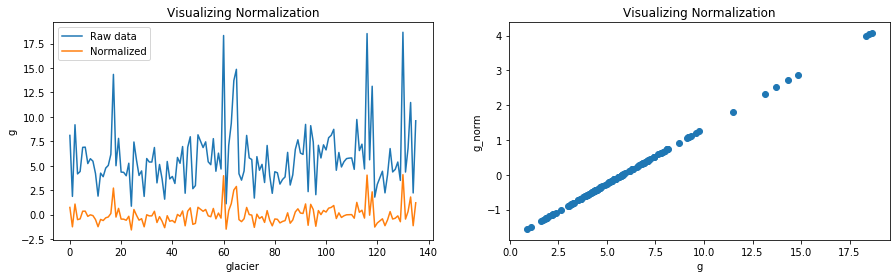

In [76]:
#visualize normalization

plt.figure(figsize=[15,4])

plt.subplot(1,2,1)
plt.plot(data['g'])
plt.plot(data_norm['g'])
plt.legend(['Raw data','Normalized'])
plt.ylabel('g')
plt.xlabel('glacier')
plt.title('Visualizing Normalization')

plt.subplot(1,2,2)
plt.scatter(data['g'],data_norm['g'])
plt.ylabel('g_norm')
plt.xlabel('g')
plt.title('Visualizing Normalization')

plt.show()

In [77]:
#unpack normalized data
lat = data_norm['lat']
lon = data_norm['lon']
hmax = data_norm['max_elevation']
hmed = data_norm['median_elevation']
g = data_norm['g']
Pannual = data_norm['precipitation']
Pwinter = data_norm['winter_precipitation']
CI = data_norm['continentality']
cloud = data_norm['cloud_cover']
Tsummer = data_norm['summer_temperature']

SOLUTIONS

What are the most characteristic features in the space of these variables across the glaciers?  Apply PCA on the data with 10 variables and 136 observations to find out!  Eigenvectors (which carry most of the variance) will represent the characteristic features.

In [98]:
#do PCA using built-in library

n_modes = np.shape(data_norm)[1]
pca = PCA(n_components = n_modes)
PCs = pca.fit_transform(data_norm)
eigvecs = pca.components_
fracVar = pca.explained_variance_ratio_

In [99]:
#investigate: did PCA work as we expected?  What size of variables do we expect?

nObservations = np.shape(data_norm)[0] #number of images
nVariables = np.shape(data_norm)[1] #number of pixels in each image (i.e. the number of variables that defines each observation)

print('Expected sizes:')
print('\t' + str(nVariables) + ' eigenvectors, each of length ' + str(nVariables))
print('\t' + str(nVariables) + ' eigenvalues, one for each eigenvector')
print('\t' + str(nVariables) + ' PCs, each of length ' + str(nObservations))

print('Actual sizes:')
print('\t' + str(np.shape(eigvecs)[0]) + ' eigenvectors, each of length ' + str(np.shape(eigvecs)[1]))
print('\t' + str(len(fracVar)) + ' eigenvalues')
print('\t' + str(np.shape(PCs)[1]) + ' PCs, each of length ' + str(np.shape(PCs)[0]))


Expected sizes:
	10 eigenvectors, each of length 10
	10 eigenvalues, one for each eigenvector
	10 PCs, each of length 135
Actual sizes:
	10 eigenvectors, each of length 10
	10 eigenvalues
	10 PCs, each of length 135


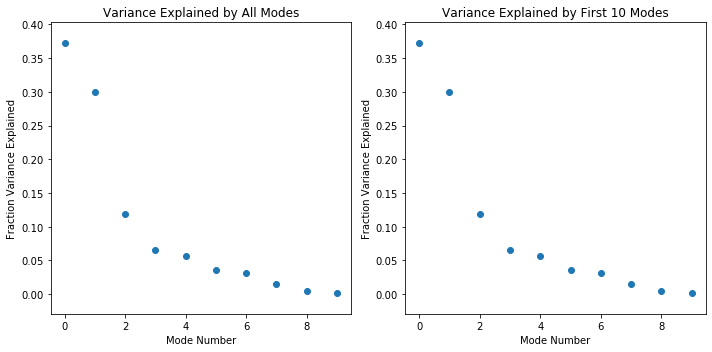

In [100]:
#plot fraction of variance explained by each mode

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(range(len(fracVar)),fracVar)
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('Variance Explained by All Modes')

plt.subplot(1,2,2)
n_modes_show = 10
plt.scatter(range(n_modes_show),fracVar[:n_modes_show])
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('Variance Explained by First ' + str(n_modes_show) + ' Modes')

plt.tight_layout()

plt.show()

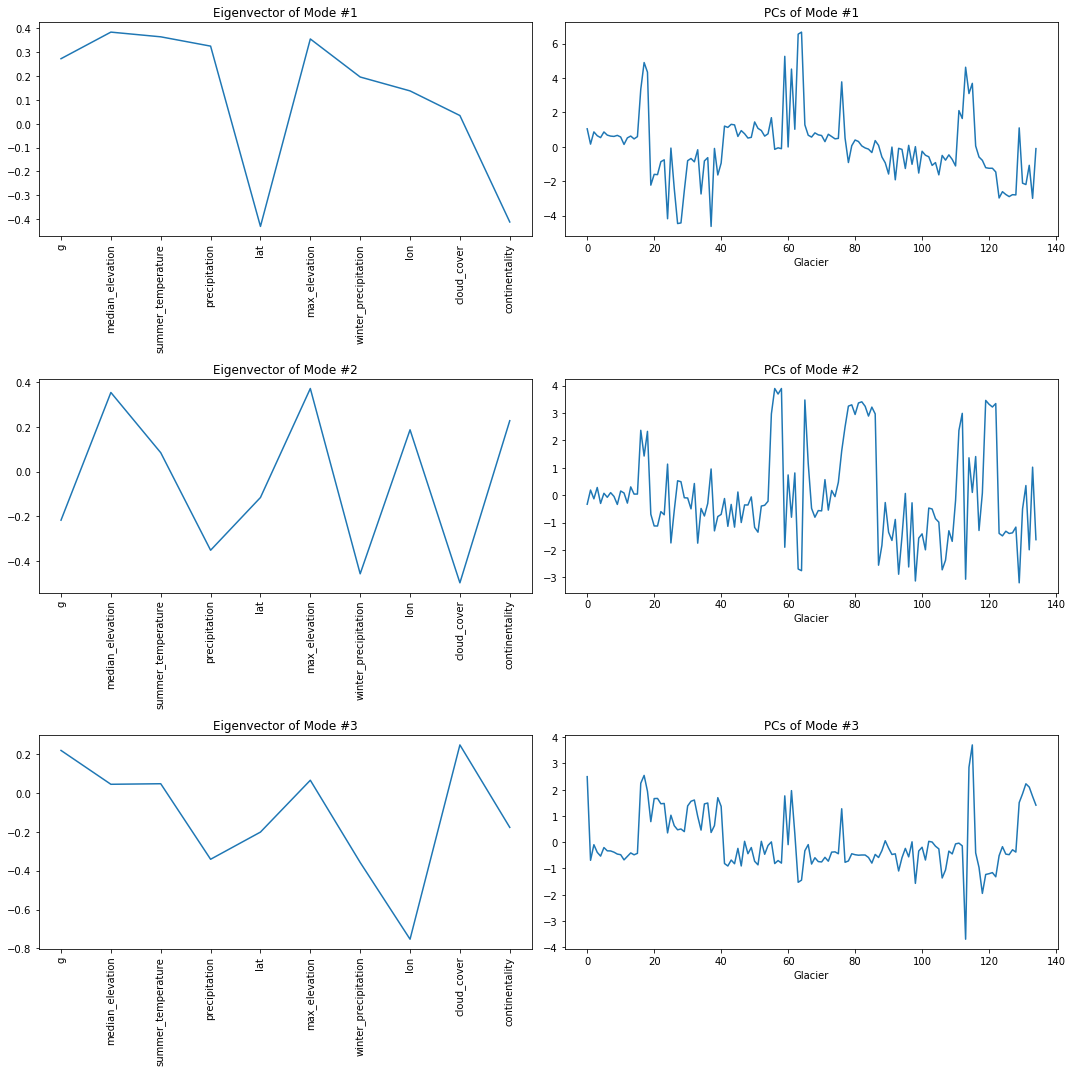

In [101]:
#plot the first n modes and PCs -- choose a value of 'n' from the variance explained figure!

n = 3

plt.figure(figsize=(15,5*n))
for kk in range(n):
    
    plt.subplot(n,2,kk*2+1)
    plt.plot(list(data_norm.columns),eigvecs[kk,:])
    plt.xticks(rotation=90)
    plt.title('Eigenvector of Mode #' + str(kk+1))
    
    plt.subplot(n,2,(kk+1)*2)
    plt.plot(PCs[:,kk])
    plt.title('PCs of Mode #' + str(kk+1))
    plt.xlabel('Glacier')
    
    plt.tight_layout()

Reconstruct the data using fewer modes.  Which glaciers are most accurately reconstructed?

In [102]:
# Ok, so we've chosen to keep the first n modes.  Now, reconstruct!

numModes = n
numObs = np.shape(data_norm)[0]

data_rec = np.empty_like(data_norm)

for kk in range(numObs): #for each glacier
    
    this_glacier_rec = np.zeros_like(data_norm.iloc[0,:])
    
    for mode in range(numModes):
        
        this_glacier_rec += eigvecs[mode,:]*PCs[kk,mode]
        
    data_rec[kk,:] = this_glacier_rec
    
#fea_rec += fea.mean().mean()

In [103]:
#find minimum RMSE between reconstruction and original

error = data_norm - data_rec
RMSE = np.sqrt(np.sum(error**2,axis=1)/32/32)

minRMSE = np.min(RMSE)
ind_minRMSE = np.argmin(RMSE)

RMSE_sort = np.sort(RMSE)
RMSE_sort_inds = np.argsort(RMSE,axis=0)

/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


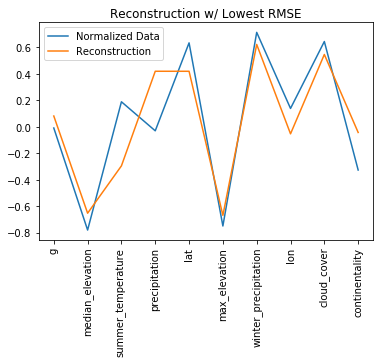

In [104]:
#plot glacier characteristics of glacier which has minimum RMSE

plt.plot(data_norm.iloc[ind_minRMSE,:])
plt.plot(data_rec[ind_minRMSE,:])
plt.legend(['Normalized Data','Reconstruction'])
plt.title('Reconstruction w/ Lowest RMSE')
plt.xticks(rotation=90)
plt.show()

#cool, it does pretty well!

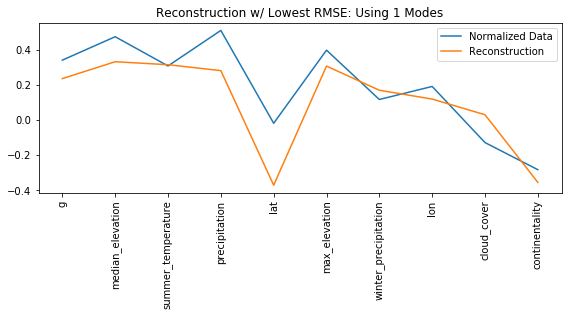

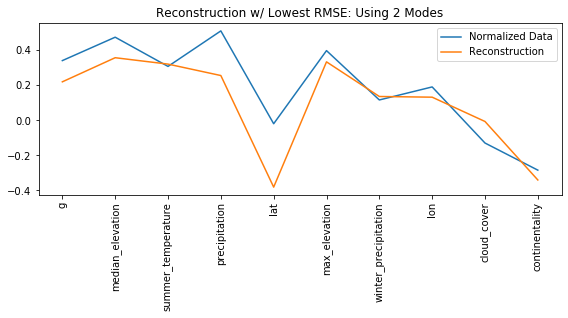

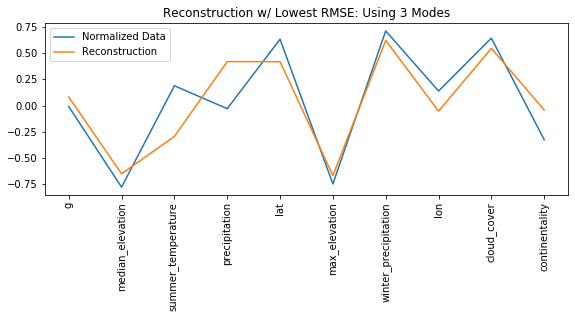

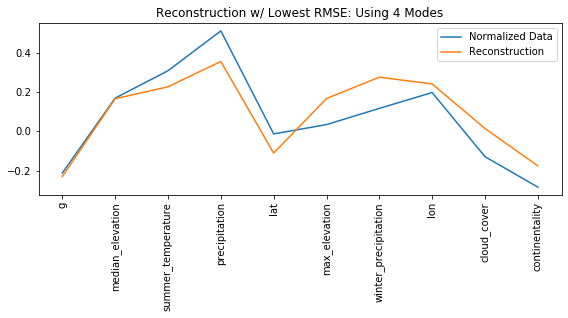

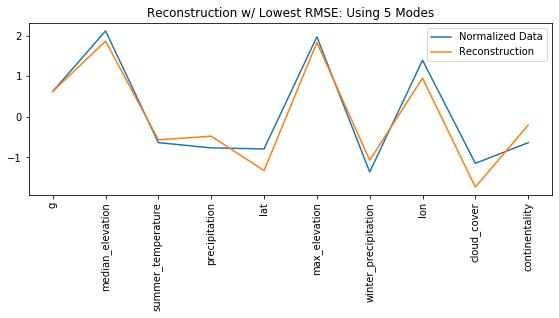

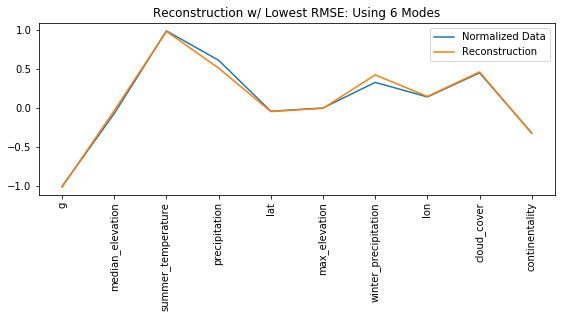

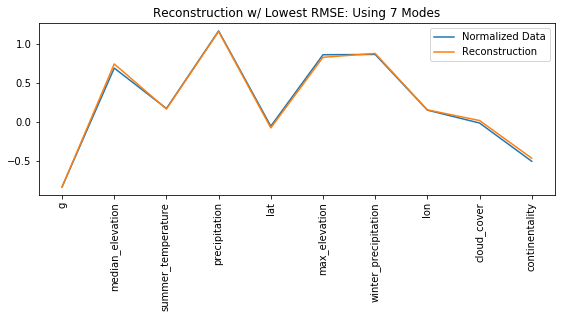

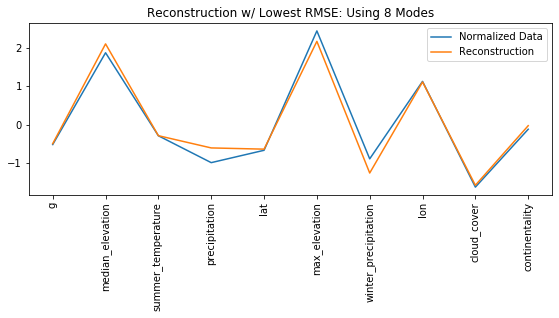

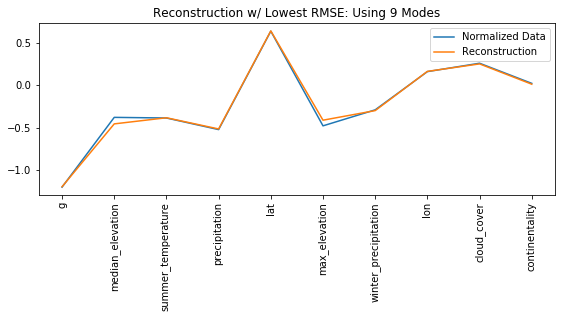

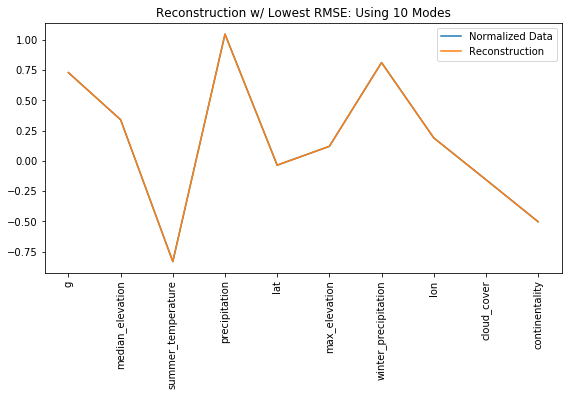

In [105]:
#Does the best reconstruction get even better if you increase the number of modes used in the reconstruction?

numObs = np.shape(data_norm)[0]

numModes_to_test = range(1,11)

for numModes in numModes_to_test: #loop through varying number of modes 

    data_rec = np.empty_like(data_norm)

    for kk in range(numObs): #for each glacier

        this_glacier_rec = np.zeros_like(data_norm.iloc[0,:])

        for mode in range(numModes):

            this_glacier_rec += eigvecs[mode,:]*PCs[kk,mode]

        data_rec[kk,:] = this_glacier_rec
        
    #find minimum RMSE between reconstruction and original

    error = data_norm - data_rec
    RMSE = np.sqrt(np.sum(error**2,axis=1)/32/32)

    minRMSE = np.min(RMSE)
    ind_minRMSE = np.argmin(RMSE)

    RMSE_sort = np.sort(RMSE)
    RMSE_sort_inds = np.argsort(RMSE,axis=0)
    
    plt.figure(figsize=(8,4*len(numModes_to_test)))
    plt.subplot(len(numModes_to_test),1,numModes)
    plt.plot(data_norm.iloc[ind_minRMSE,:])
    plt.plot(data_rec[ind_minRMSE,:])
    plt.legend(['Normalized Data','Reconstruction'])
    plt.title('Reconstruction w/ Lowest RMSE: Using ' + str(numModes) + ' Modes')
    plt.xticks(rotation=90)
    plt.tight_layout()

In [106]:
#visualize PC space

sliderPC1 = ipywidgets.FloatSlider(value = 0, min=-10, max = 10, description = 'PC1', continuous_update=False)
sliderPC2 = ipywidgets.FloatSlider(value = 0, min=-10, max = 10, description = 'PC2', continuous_update=False)
#PC1 = PCs[:,0]
#PC2 = PCs[:,2]
PC_1_2 = pd.DataFrame(data = [PC1,PC2]).T

@ipywidgets.interact(PC1 = sliderPC1, PC2 = sliderPC2, eigvecs = eigvecs, PCs = PCs)

def plot_PCs(PC1,PC2):

    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.scatter(PCs[:,0],PCs[:,1])
    plt.scatter(PC1,PC2,c='k',s = 20)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('PC Space')
    
    plt.subplot(1,2,2)
    yrec = eigvecs[0,:]*PC1 + eigvecs[1,:]*PC2
    plt.plot(yrec)
    plt.title('Reconstructed Data')
    
    plt.tight_layout()
    
    plt.show()

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='PC1', max=10.0, min=-10.0),…

What happens when you transpose the input matrix to PCA?

In [86]:
#print data transpose.  What are we now applying PCA on?

data_norm.T

,0,1,2,3,4,5,6,7,8,9,...,126,127,128,129,130,131,132,133,134,135
g,0.729295,-1.252792,1.075809,-0.521870,-0.442849,0.341358,0.347983,-0.186006,-0.028100,-0.107773,...,-0.458226,-0.373960,-0.135945,-0.732913,4.082598,-0.461272,0.312033,1.799200,-1.140466,1.204881
median_elevation,-1.127617,0.077903,0.002036,0.366006,0.180323,0.474938,0.218256,0.267569,0.153769,0.267569,...,-1.560815,-1.689788,-1.697374,-1.636681,-0.718696,-1.333215,-0.544203,-1.105615,-0.400056,-0.483510
summer_temperature,-0.610002,0.303656,1.032093,0.308183,0.054305,0.308183,0.303656,0.308183,-0.066410,0.054305,...,-2.234368,-2.185327,-1.903912,-1.604766,0.404000,-0.323683,0.256879,-0.177693,-0.405542,0.075430
precipitation,-1.008986,0.634920,0.469699,0.510896,0.761253,0.510896,0.634920,0.510896,0.669535,0.761253,...,-0.501419,-0.514405,-0.641892,-0.712866,0.429471,-0.825336,-1.413473,-0.476557,-1.600750,-0.157370
lat,-4.510634,-0.009790,0.009659,-0.020399,-0.018189,-0.019073,-0.009348,-0.021283,-0.006696,-0.018189,...,1.394126,1.397663,1.388380,1.317212,0.030877,0.620558,0.708081,0.491482,0.973747,0.048117
max_elevation,-1.305564,0.000761,-0.028636,0.563344,0.140396,0.398354,0.096301,0.346175,0.467437,0.155095,...,-1.395592,-1.689561,-1.748355,-1.571973,-0.884086,0.037507,-0.359351,-1.138369,-0.182970,-0.590852
winter_precipitation,-0.826765,0.080425,-0.047412,0.116703,0.383669,0.116703,0.080425,0.116703,0.135622,0.383669,...,-0.141377,-0.160869,-0.313530,-0.287175,1.825171,-0.742943,-1.384616,-0.229353,-1.378192,0.765539
lon,-0.917411,0.221562,0.230660,0.190768,0.182089,0.191048,0.221282,0.194127,0.212044,0.181389,...,0.221702,0.208964,0.207984,0.255016,-1.658436,-2.015930,-1.995214,-1.840402,-1.973098,-1.654376
cloud_cover,-0.073330,-0.285946,-0.311797,-0.129189,0.038174,-0.129189,-0.285946,-0.129189,-0.127430,0.038174,...,0.542450,0.382869,0.422151,0.630290,0.748084,1.098482,0.730708,1.343131,0.323705,0.660831
continentality,-1.567918,-0.270948,-0.119936,-0.283999,-0.392131,-0.283999,-0.270948,-0.283999,-0.341794,-0.392131,...,-0.015532,-0.032311,-0.116207,0.060285,-0.366652,1.088167,1.816508,0.125538,2.055146,-0.154737


In [87]:
#do PCA using built-in library

n_modes = np.min(np.shape(data_norm.T))
pca = PCA(n_components = n_modes)
PCs = pca.fit_transform(data_norm.T)
eigvecs = pca.components_
fracVar = pca.explained_variance_ratio_

In [88]:
#investigate: did PCA work as we expected?  What size of variables do we expect?

nObservations = np.shape(data_norm.T)[0] #number of characteristics
nVariables = np.shape(data_norm.T)[1] #number of glaciers (i.e. the number of variables that defines each observation)

print('Expected sizes:')
print('\t' + str(nVariables) + ' eigenvectors, each of length ' + str(nVariables))
print('\t' + str(nVariables) + ' eigenvalues, one for each eigenvector')
print('\t' + str(nVariables) + ' PCs, each of length ' + str(nObservations))

print('Actual sizes:')
print('\t' + str(np.shape(eigvecs)[0]) + ' eigenvectors, each of length ' + str(np.shape(eigvecs)[1]))
print('\t' + str(len(fracVar)) + ' eigenvalues')
print('\t' + str(np.shape(PCs)[1]) + ' PCs, each of length ' + str(np.shape(PCs)[0]))


Expected sizes:
	135 eigenvectors, each of length 135
	135 eigenvalues, one for each eigenvector
	135 PCs, each of length 10
Actual sizes:
	10 eigenvectors, each of length 135
	10 eigenvalues
	10 PCs, each of length 10


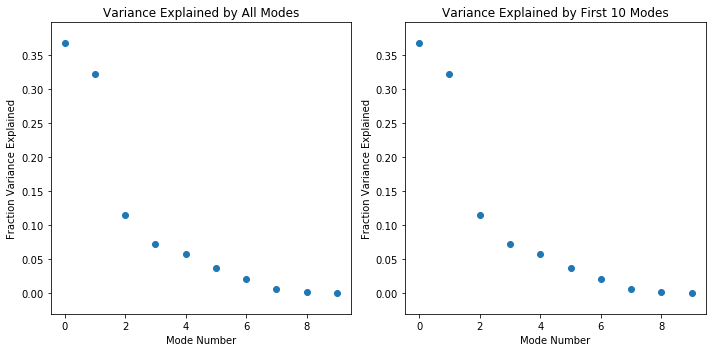

In [89]:
#plot fraction of variance explained by each mode

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(range(len(fracVar)),fracVar)
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('Variance Explained by All Modes')

plt.subplot(1,2,2)
n_modes_show = 10
plt.scatter(range(n_modes_show),fracVar[:n_modes_show])
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('Variance Explained by First ' + str(n_modes_show) + ' Modes')

plt.tight_layout()

plt.show()

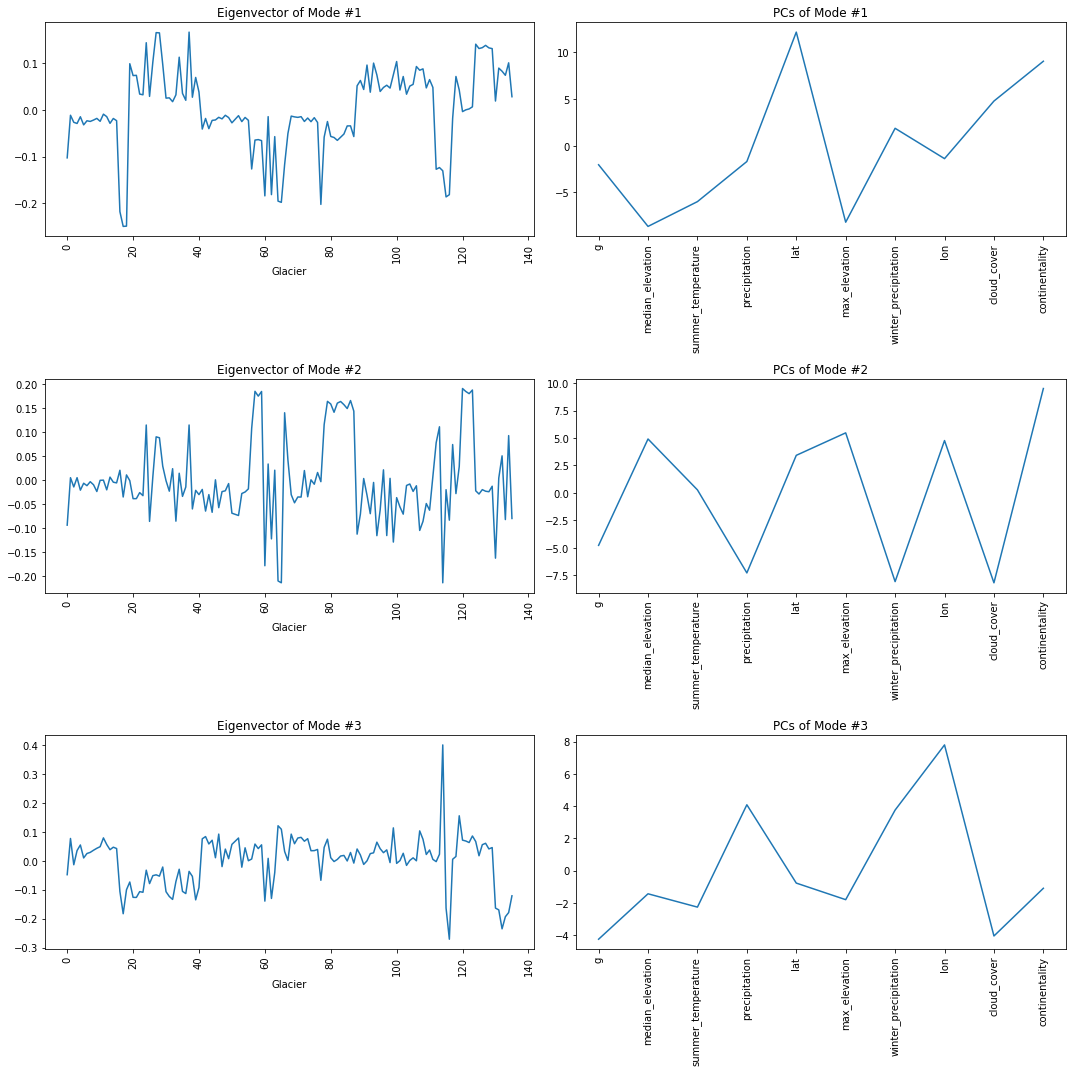

In [90]:
#plot the first n modes and PCs -- choose a value of 'n' from the variance explained figure!

n = 3

plt.figure(figsize=(15,5*n))
for kk in range(n):
    
    plt.subplot(n,2,kk*2+1)
    plt.plot(list(data_norm.T.columns),eigvecs[kk,:])
    plt.xticks(rotation=90)
    plt.title('Eigenvector of Mode #' + str(kk+1))
    plt.xlabel('Glacier')
    
    plt.subplot(n,2,(kk+1)*2)
    plt.plot(list(data_norm.columns),PCs[:,kk])
    plt.title('PCs of Mode #' + str(kk+1))
    plt.xticks(rotation=90)
    
    plt.tight_layout()

In [96]:
#visualize PC space

sliderPC1 = ipywidgets.FloatSlider(value = 0, min=-10, max = 10, description = 'PC1', continuous_update=False)
sliderPC2 = ipywidgets.FloatSlider(value = 0, min=-10, max = 10, description = 'PC2', continuous_update=False)
#PC1 = PCs[:,0]
#PC2 = PCs[:,2]
PC_1_2 = pd.DataFrame(data = [PC1,PC2]).T

@ipywidgets.interact(PC1 = sliderPC1, PC2 = sliderPC2, eigvecs = eigvecs, PCs = PCs)

def plot_PCs(PC1,PC2):

    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.scatter(PCs[:,0],PCs[:,1])
    plt.scatter(PC1,PC2,c='k',s = 20)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('PC Space')
    
    plt.subplot(1,2,2)
    yrec = eigvecs[0,:]*PC1 + eigvecs[1,:]*PC2
    plt.plot(yrec)
    plt.title('Reconstructed Data')
    
    plt.tight_layout()
    
    plt.show()
    
    

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='PC1', max=10.0, min=-10.0),…